<a href="https://colab.research.google.com/github/Adhii04/BreastCancerDetetctionModel/blob/main/BreastCancerDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BREAST CANCER DETECTION USING CONVOLUTION NEURAL NETWORK (CNN)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 # OpenCV for image processing

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
root_data_dir = '/content/drive/MyDrive/breast'

class_names = ['benign', 'malignant']
label_map = {name: i for i, name in enumerate(class_names)} # {'benign': 0, 'malignant': 1}

image_paths = []
labels = []

# Traverse the directory structure
print(f"Scanning directory: {root_data_dir}")
for class_name in class_names:
    class_dir = os.path.join(root_data_dir, class_name)
    print(f"Entering class directory: {class_dir}")
    # os.walk is perfect for traversing deep nested directories
    found_images_in_class = 0 # Counter for images in this specific class
    for subdir, dirs, files in os.walk(class_dir):
        for file in files:
            # Ensure it's an image file (you might need to add more extensions)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff', '.dcm')):
                img_path = os.path.join(subdir, file)
                image_paths.append(img_path)
                labels.append(label_map[class_name])
                found_images_in_class += 1
                # print(f"Found: {img_path} (Label: {class_name})") # Uncomment for debugging if needed

    print(f"  Found {found_images_in_class} images in {class_name} folder.")

Scanning directory: /content/drive/MyDrive/breast
Entering class directory: /content/drive/MyDrive/breast/benign
  Found 2480 images in benign folder.
Entering class directory: /content/drive/MyDrive/breast/malignant
  Found 5429 images in malignant folder.


In [5]:
# Create a DataFrame
df = pd.DataFrame({'path': image_paths, 'label': labels})

# Check if any images were found
if df.empty:
    raise ValueError(f"No images found in {root_data_dir}. Please check your path and folder structure and file extensions.")
else:
    print(f"\nFound {len(df)} images in total.")
    print("Class distribution:\n", df['label'].map({v: k for k, v in label_map.items()}).value_counts())
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 1 # For binary classification (output is a single probability)

# Split data into training (50%), validation (20%), and testing (30%)
# stratify ensures balanced classes in each split
train_df, temp_df = train_test_split(df, test_size=0.50, stratify=df['label'], random_state=42)
# Split temp_df (50% of original) into validation (20% of original) and test (30% of original)
# 20% of total is 40% of temp_df (0.20 / 0.50 = 0.4)
# 30% of total is 60% of temp_df (0.30 / 0.50 = 0.6)
val_df, test_df = train_test_split(temp_df, test_size=0.6, stratify=temp_df['label'], random_state=42)

print(f"\nData Split Ratios:")
print(f"  Training images: {len(train_df)} ({len(train_df)/len(df)*100:.2f}%)")
print(f"  Validation images: {len(val_df)} ({len(val_df)/len(df)*100:.2f}%)")
print(f"  Test images: {len(test_df)} ({len(test_df)/len(df)*100:.2f}%)")


Found 7909 images in total.
Class distribution:
 label
malignant    5429
benign       2480
Name: count, dtype: int64

Data Split Ratios:
  Training images: 3954 (49.99%)
  Validation images: 1582 (20.00%)
  Test images: 2373 (30.00%)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
    seed=42
)

print("\nData Generators created successfully.")
print(f"Defined class mapping: {label_map}")


Found 3954 validated image filenames.
Found 1582 validated image filenames.
Found 2373 validated image filenames.

Data Generators created successfully.
Defined class mapping: {'benign': 0, 'malignant': 1}


DEFINING CNN MODEL


In [ ]:
print("\n--- Defining CNN Model ---")
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid') # Sigmoid for binary classification (output 0-1 probability)
    ])
    return model

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3) # Assuming RGB images
model = build_cnn_model(input_shape, NUM_CLASSES)
model.summary()


--- Defining CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,849 (84.86 MB)

 Trainable params: 22,245,889 (84.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
print("\n--- Compiling Model ---")
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Appropriate for binary classification with sigmoid output
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])


--- Compiling Model ---


In [ ]:
print("\n--- Training Model ---")


--- Training Model ---


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_breast_cancer_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


In [ ]:
steps_per_epoch_train = train_generator.samples // BATCH_SIZE
if train_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch_train += 1

steps_per_epoch_val = validation_generator.samples // BATCH_SIZE
if validation_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch_val += 1

epochs = 25 # Start with a reasonable number, EarlyStopping will prevent overfitting

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\nModel training complete.")

Epoch 1/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.7522 - auc: 0.8034 - loss: 0.6602 - precision: 0.8451 - recall: 0.7769 
Epoch 1: val_loss improved from inf to 40.18707, saving model to best_breast_cancer_model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 4042s 33s/step - accuracy: 0.7523 - auc: 0.8035 - loss: 0.6595 - precision: 0.8450 - recall: 0.7772 - val_accuracy: 0.6865 - val_auc: 0.5000 - val_loss: 40.1871 - val_precision: 0.6865 - val_recall: 1.0000
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.8111 - auc: 0.8548 - loss: 0.4483 - precision: 0.8438 - recall: 0.8852
Epoch 2: val_loss improved from 40.18707 to 1.35983, saving model to best_breast_cancer_model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8110 - auc: 0.8548 - loss: 0.4484 - precision: 0.8438 - recall: 0.8851 - val_accuracy: 0.6909 - val_auc: 0.7045 - val_loss: 1.3598 - val_precision: 0.6957 - val_recall: 0.9770
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.8180 - auc: 0.8716 - loss: 0.4244 - precision: 0.8396 - recall: 0.8997
Epoch 3: val_loss improved from 1.35983 to 1.05030, saving model to best_breast_cancer_model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8181 - auc: 0.8716 - loss: 0.4243 - precision: 0.8398 - recall: 0.8997 - val_accuracy: 0.6884 - val_auc: 0.7407 - val_loss: 1.0503 - val_precision: 0.6878 - val_recall: 1.0000
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.8473 - auc: 0.9057 - loss: 0.3565 - precision: 0.8762 - recall: 0.9110
Epoch 4: val_loss did not improve from 1.05030
124/124 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8472 - auc: 0.9056 - loss: 0.3567 - precision: 0.8761 - recall: 0.9109 - val_accuracy: 0.6833 - val_auc: 0.6819 - val_loss: 1.2547 - val_precision: 0.6891 - val_recall: 0.9816
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8449 - auc: 0.9123 - loss: 0.3473 - precision: 0.8740 - recall: 0.9063
Epoch 5: val_loss did not improve from 1.05030
124/124 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8449 - auc: 0.9123 - loss: 0.3473 - precision: 0.8741 - recall: 0.9063 - val_accuracy: 0.6896 - val_auc: 0.6

124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8617 - auc: 0.9232 - loss: 0.3269 - precision: 0.8804 - recall: 0.9231 - val_accuracy: 0.7762 - val_auc: 0.8737 - val_loss: 0.5259 - val_precision: 0.7607 - val_recall: 0.9834
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8612 - auc: 0.9289 - loss: 0.3223 - precision: 0.8788 - recall: 0.9212
Epoch 8: val_loss did not improve from 0.52590
124/124 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8612 - auc: 0.9289 - loss: 0.3222 - precision: 0.8789 - recall: 0.9211 - val_accuracy: 0.7067 - val_auc: 0.6854 - val_loss: 1.0490 - val_precision: 0.7009 - val_recall: 0.9991
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.8763 - auc: 0.9385 - loss: 0.2915 - precision: 0.8910 - recall: 0.9354
Epoch 9: val_loss improved from 0.52590 to 0.28220, saving model to best_breast_cancer_model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8762 - auc: 0.9385 - loss: 0.2916 - precision: 0.8910 - recall: 0.9353 - val_accuracy: 0.8875 - val_auc: 0.9438 - val_loss: 0.2822 - val_precision: 0.8962 - val_recall: 0.9457
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.8765 - auc: 0.9404 - loss: 0.2840 - precision: 0.8988 - recall: 0.9245
Epoch 10: val_loss did not improve from 0.28220
124/124 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8765 - auc: 0.9404 - loss: 0.2841 - precision: 0.8988 - recall: 0.9245 - val_accuracy: 0.8432 - val_auc: 0.8600 - val_loss: 0.8006 - val_precision: 0.8384 - val_recall: 0.9558
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.8766 - auc: 0.9406 - loss: 0.2882 - precision: 0.9029 - recall: 0.9178
Epoch 11: val_loss did not improve from 0.28220
124/124 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8766 - auc: 0.9406 - loss: 0.2882 - precision: 0.9029 - recall: 0.9178 - val_accuracy: 0.8243 - val_auc:

124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9064 - auc: 0.9674 - loss: 0.2146 - precision: 0.9325 - recall: 0.9291 - val_accuracy: 0.8932 - val_auc: 0.9576 - val_loss: 0.2481 - val_precision: 0.9281 - val_recall: 0.9153
Epoch 25/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9015 - auc: 0.9622 - loss: 0.2313 - precision: 0.9268 - recall: 0.9297
Epoch 25: val_loss improved from 0.24808 to 0.21865, saving model to best_breast_cancer_model.h5


124/124 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9016 - auc: 0.9622 - loss: 0.2313 - precision: 0.9268 - recall: 0.9297 - val_accuracy: 0.9096 - val_auc: 0.9681 - val_loss: 0.2187 - val_precision: 0.9147 - val_recall: 0.9576
Restoring model weights from the end of the best epoch: 25.

Model training complete.



--- Evaluating Model on Test Set ---


Loaded best model from 'best_breast_cancer_model.h5'
75/75 ━━━━━━━━━━━━━━━━━━━━ 1747s 24s/step - accuracy: 0.9013 - auc: 0.9615 - loss: 0.2440 - precision: 0.9062 - recall: 0.9548

Test Loss: 0.2505
Test Accuracy: 0.8959
Test Precision: 0.9027 (For Malignant class)
Test Recall (Sensitivity): 0.9509 (For Malignant class)
Test AUC: 0.9589
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 527ms/step

Classification Report (Target 0: Benign/No Cancer, Target 1: Malignant/Has Cancer):
              precision    recall  f1-score   support

      benign       0.88      0.78      0.82       744
   malignant       0.90      0.95      0.93      1629

    accuracy                           0.90      2373
   macro avg       0.89      0.86      0.87      2373
weighted avg       0.90      0.90      0.89      2373


Confusion Matrix:


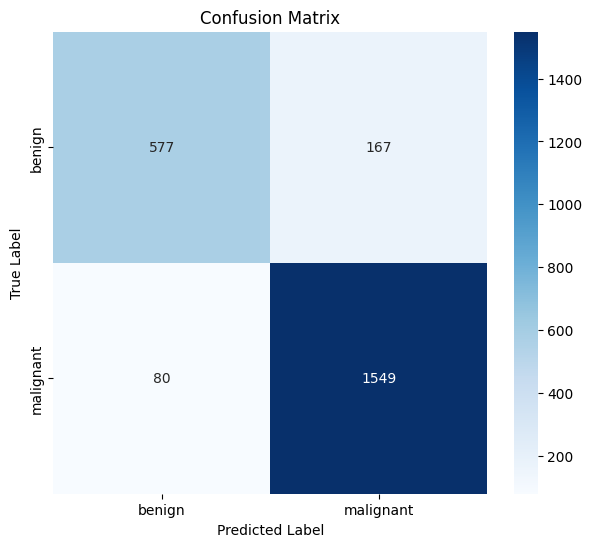

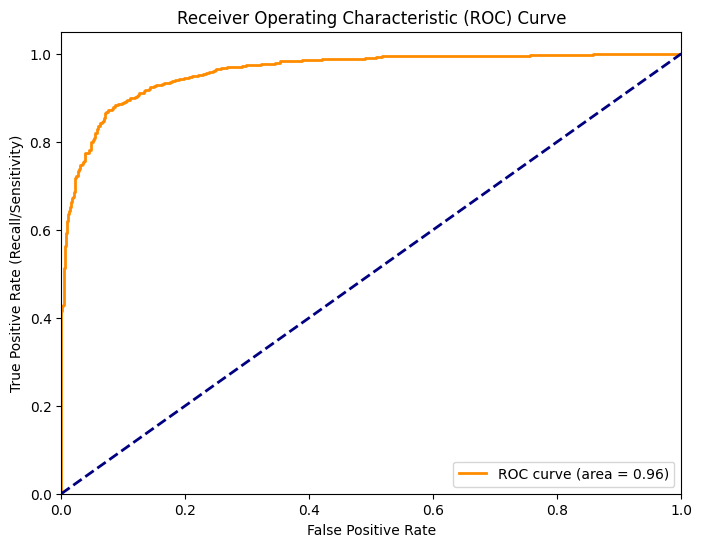

In [ ]:
print("\n--- Evaluating Model on Test Set ---")
# Load the best model saved by ModelCheckpoint
try:
    best_model = tf.keras.models.load_model('best_breast_cancer_model.h5')
    print("Loaded best model from 'best_breast_cancer_model.h5'")
except Exception as e:
    print(f"Could not load best model, using the last trained model. Error: {e}")
    best_model = model # Fallback to the last trained model

test_generator.reset() # Important to reset generator before evaluation/prediction
# Calculate steps for evaluation, ensuring all samples are processed
steps_for_test_eval = test_generator.samples // BATCH_SIZE
if test_generator.samples % BATCH_SIZE != 0:
    steps_for_test_eval += 1

test_results = best_model.evaluate(test_generator, steps=steps_for_test_eval, verbose=1)
test_loss, test_accuracy, test_precision, test_recall, test_auc = test_results

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f} (For Malignant class)")
print(f"Test Recall (Sensitivity): {test_recall:.4f} (For Malignant class)")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions for Classification Report and Confusion Matrix
test_generator.reset() # Reset again for consistent prediction order
# Ensure all samples are predicted
y_pred_proba = best_model.predict(test_generator, steps=steps_for_test_eval, verbose=1).flatten()
y_pred_class = (y_pred_proba > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)

# Get true labels from the test generator
# Ensure y_true aligns with the number of predictions made
y_true = test_generator.labels[:len(y_pred_class)]

print("\nClassification Report (Target 0: Benign/No Cancer, Target 1: Malignant/Has Cancer):")
# Use class_names for target_names to make the report more readable
print(classification_report(y_true, y_pred_class, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall/Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



--- Visualizing Training History ---


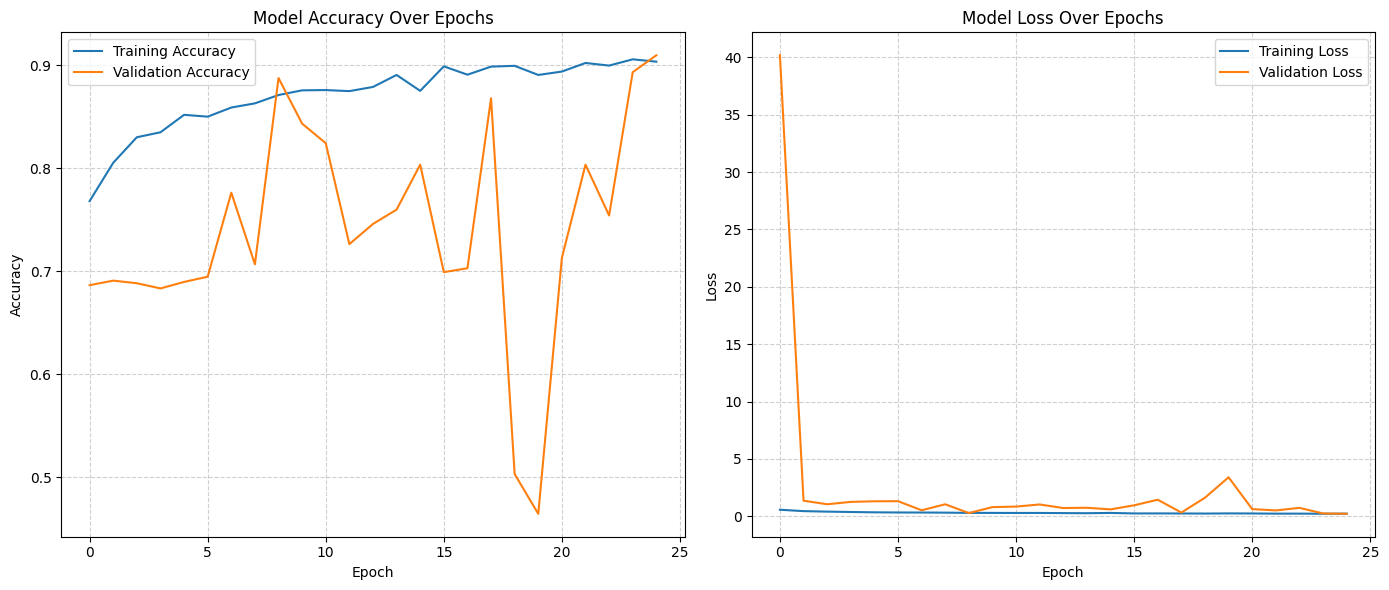

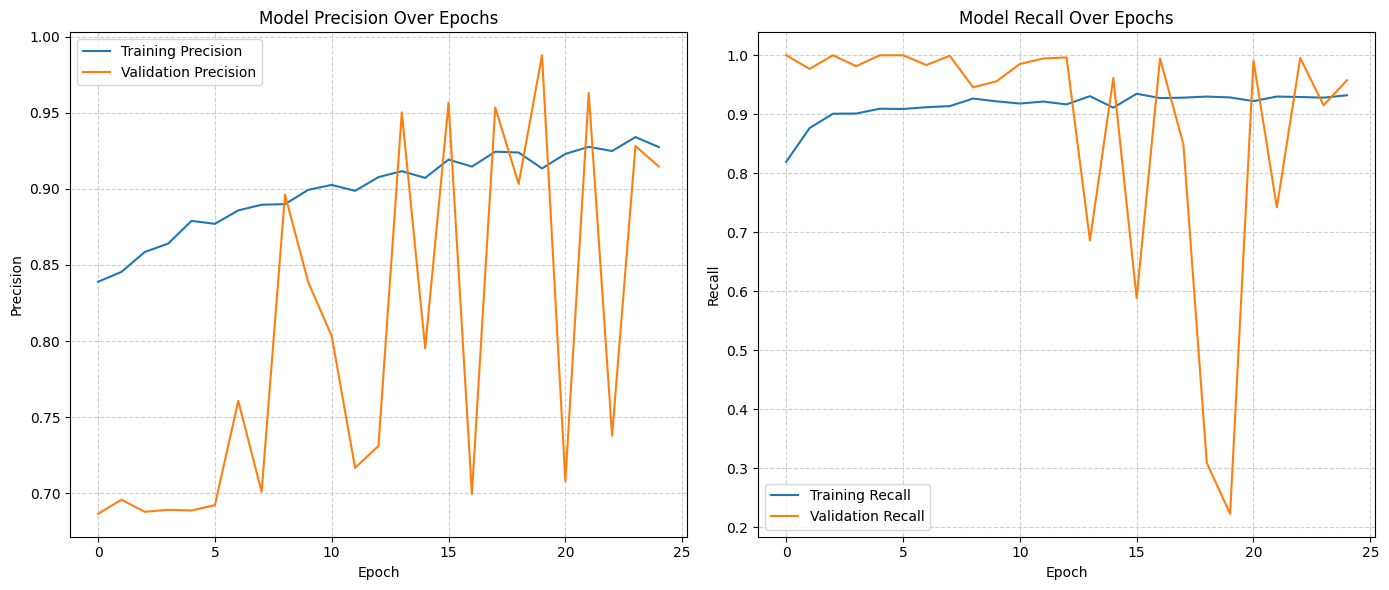

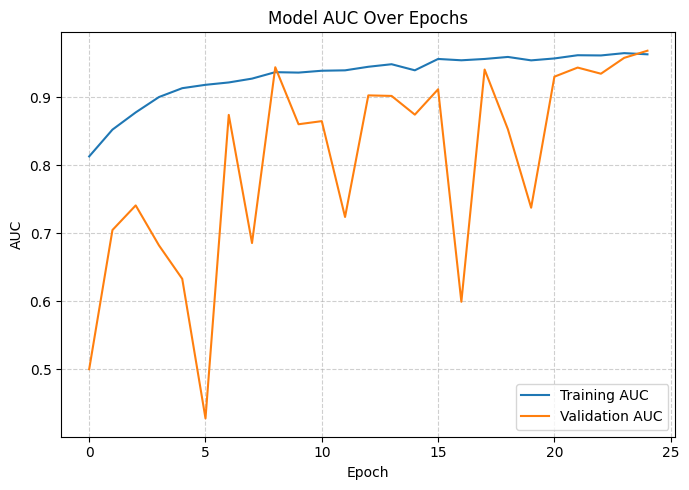


--- Visualizing Sample Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


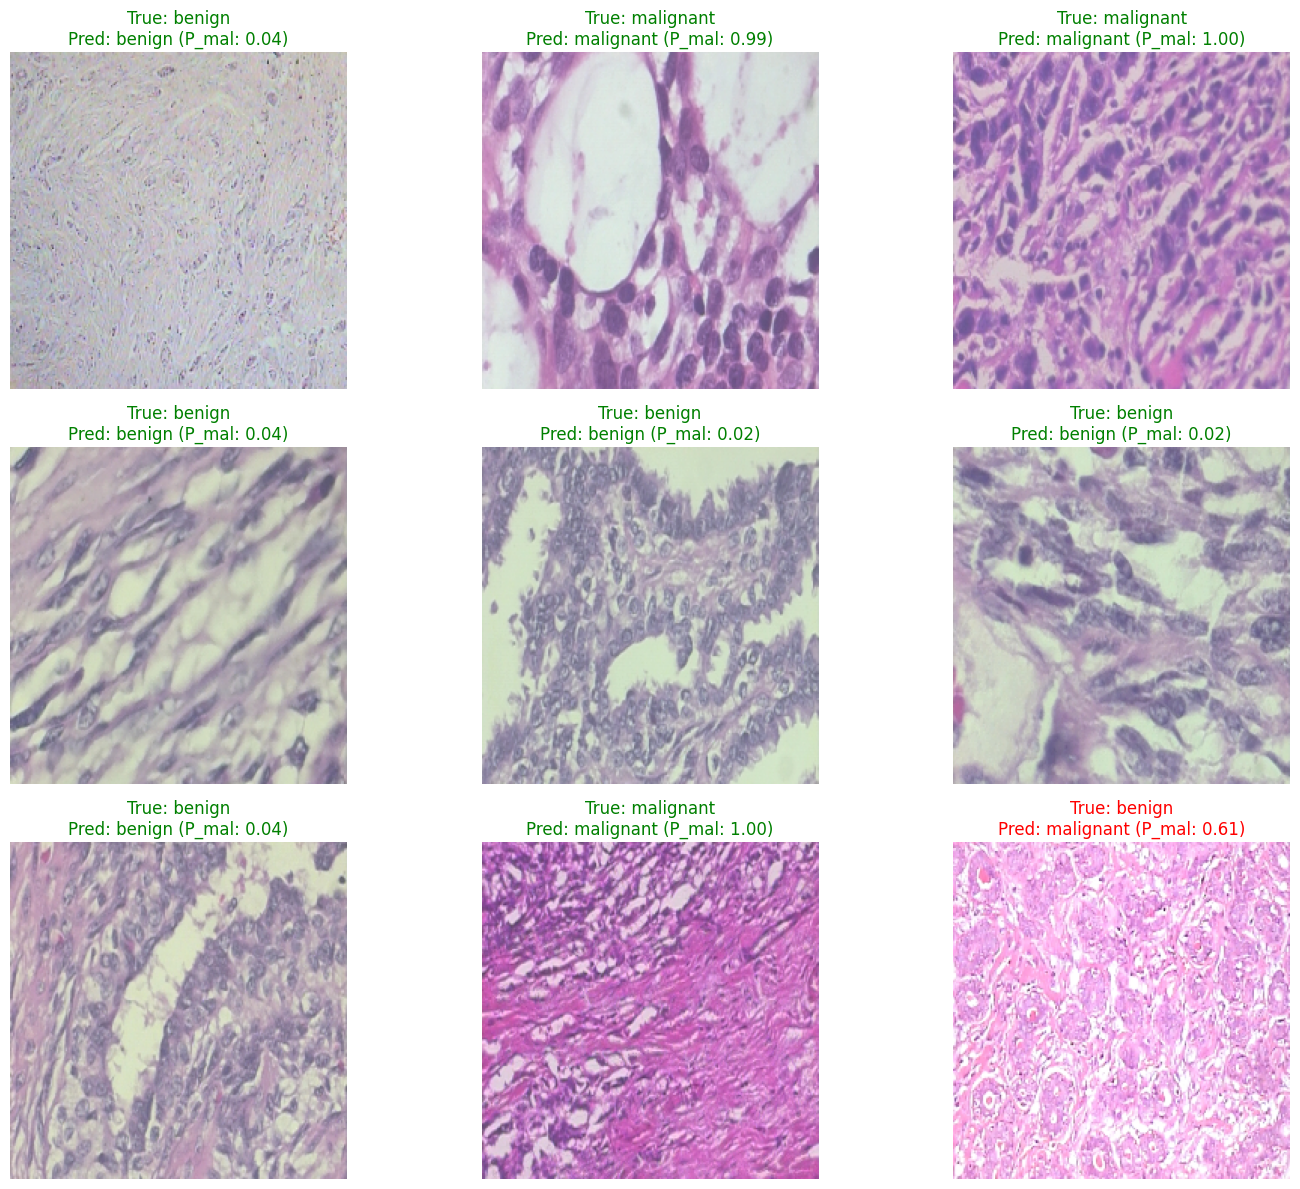


Project execution complete. Review the outputs for model performance.


In [ ]:
print("\n--- Visualizing Training History ---")
# Plot training history
plt.figure(figsize=(14, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Plot other metrics if available in history
if 'auc' in history.history:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


print("\n--- Visualizing Sample Predictions ---")
# Get a batch of test images and labels
# Reset the generator to get fresh samples, not just the remainder from evaluation
test_generator.reset()
test_images_batch, test_labels_batch = next(test_generator) # Get the first batch

# Make predictions on this batch
predictions_batch = best_model.predict(test_images_batch)
y_pred_proba_batch = predictions_batch.flatten()
predicted_classes_batch = (y_pred_proba_batch > 0.5).astype(int)

plt.figure(figsize=(15, 12))
for i in range(min(9, len(test_images_batch))): # Display up to 9 images from the batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images_batch[i]) # Images are already rescaled [0,1]

    true_label_idx = int(test_labels_batch[i]) # Ensure it's an integer index
    predicted_label_idx = predicted_classes_batch[i]

    true_label_name = class_names[true_label_idx]
    predicted_label_name = class_names[predicted_label_idx]

    color = "green" if true_label_idx == predicted_label_idx else "red"

    # Show predicted probability for malignant class
    prob_malignant = y_pred_proba_batch[i]

    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name} (P_mal: {prob_malignant:.2f})", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\nProject execution complete. Review the outputs for model performance.")